In [1]:
#Dependencies
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sqlalchemy import *
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import func, text

In [2]:
Base = automap_base()

# engine, suppose it has two tables 'user' and 'address' set up
engine = create_engine("sqlite:///hawaii.sqlite")

# reflect the tables
Base.prepare(engine, reflect=True)

# mapped classes are now created with names by default
# matching that of the table name.


In [3]:
Base.classes.keys()

['measurements', 'stations']

In [4]:
measurements = Base.classes.measurements

In [5]:
stations = Base.classes.stations

In [6]:
Base.classes.keys()

['measurements', 'stations']

In [7]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [8]:
session = Session(engine)

In [9]:
# from sqlalchemy import func
# sel = [measurements.date, measurements.prcp] 
# results = session.query(*sel).\
#     filter(measurements.date == "NA").\
#     filter(MammalMasses.status == "extant").\
#     filter(MammalMasses.comb_mass_g != None).\
#     order_by(MammalMasses.comb_mass_g.desc()).all()
# print(results[:10])

In [10]:
df = pd.DataFrame(session.query(Measurements.station, Measurements.date, Measurements.prcp, Measurements.tobs).all())
df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,0.01,73


In [11]:
# prcp_df = pd.DataFrame(x)
# prcp_df.set_index('date', inplace=True)

prcp = df[(df.date >= '2012-04-01') & (df.date <= '2013-03-31')].groupby(['date']).sum()
#prcp.drop('tobs',inplace=True, axis=1)
prcp = prcp[['prcp']]
prcp.sort_index()
prcp.head()



,prcp
date,
2012-04-01,0.05
2012-04-02,0.02
2012-04-03,0.01
2012-04-04,0.13
2012-04-05,1.52


In [12]:
x_axis = np.arange(len(prcp.prcp))
x_labels = [value for ind, value in enumerate(prcp.index) if ind % 30 == 0]


In [13]:
x_labels

['2012-04-01',
 '2012-05-01',
 '2012-05-31',
 '2012-06-30',
 '2012-07-30',
 '2012-08-29',
 '2012-09-28',
 '2012-10-28',
 '2012-11-27',
 '2012-12-27',
 '2013-01-26',
 '2013-02-25',
 '2013-03-27']

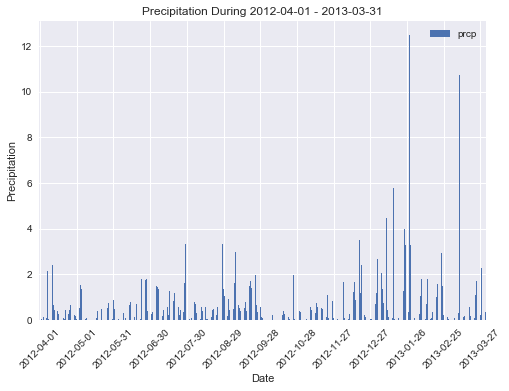

In [14]:
prcp.plot.bar()
ind = [value for ind, value in enumerate(x_axis) if ind % 30 == 0]
plt.xticks(ind, x_labels, rotation=45)
plt.title("Precipitation During " + prcp.index[0] + " - " + prcp.index[-1])
plt.xlabel("Date")
plt.ylabel("Precipitation")
sns.set()
plt.savefig('precipitation.png')
plt.show()
    

In [15]:
# Station Analysis

In [16]:
# Design a query to calculate the total number of stations.

stations = df.station.unique()
no_of_stations = len(stations)
no_of_stations

9

In [17]:
# Design a query to find the most active stations.
    # List the stations and observation counts in descending order
    # Which station has the highest number of observations?
    
active_station = df.groupby('station' , as_index = False)['prcp'].count()
active_station.set_index('prcp', inplace = True)
active_station = active_station.sort_index()

most_active_station = active_station.iloc[-1]['station']

most_active_station




'USC00519281'

In [18]:
station = df[(df.station == most_active_station) & (df.date >= '2012-04-01') & (df.date <= '2013-03-31') ].groupby(['date']).sum()
station.sort_index()
station.head()

,prcp,tobs
date,,
2012-04-01,0.00,75
2012-04-02,0.00,67
2012-04-03,0.00,66
2012-04-04,0.06,69
2012-04-05,0.11,71


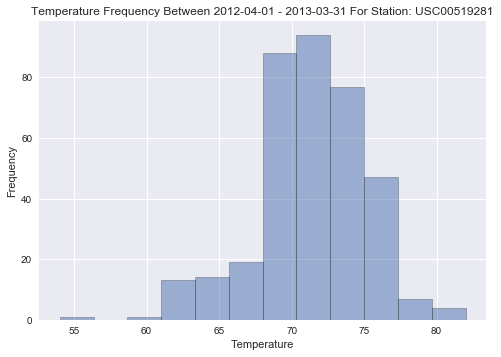

In [19]:
plt.hist(station.tobs, bins=12, alpha=0.5, edgecolor='black', linewidth='0.5')
plt.title("Temperature Frequency Between " + station.index[0] + " - " + station.index[-1] + " For Station: " + most_active_station)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
sns.set()
plt.savefig('temperature.png')
plt.show()

In [20]:
# Temperature Analysis


In [21]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d 
# and return the minimum, average, and maximum temperatures for that range of dates.

def calc_temps(start_date, end_date):
    temp_df = df[(df.date >= start_date) & (df.date <= end_date)]
    min_temp = temp_df.tobs.min()
    max_temp = temp_df.tobs.max()
    mean_temp = temp_df.tobs.mean()
    return (min_temp, max_temp, mean_temp)


In [22]:
# Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching 
# dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

min_temp, max_temp, mean_temp = calc_temps("2017-03-10", "2017-03-20")


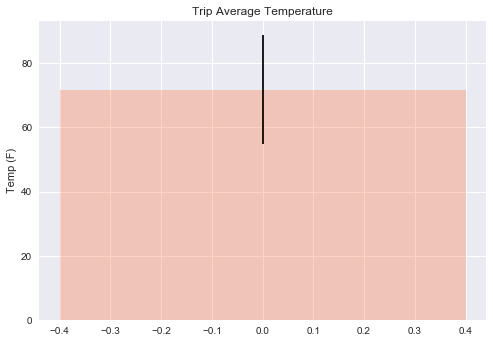

In [23]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).


ht = [mean_temp]
yerr = [max_temp - min_temp]


plt.bar(0, ht, color='coral', alpha=.35, yerr=yerr, align = 'center')
plt.ylabel("Temp (F)")
plt.title("Trip Average Temperature")



sns.set()
plt.show()
#plt.savefig('average_trip_temperature.png')




In [24]:
# Step 4 - Climate App
# Now that you have completed your initial analysis, design a Flask api based on the queries that you have just developed.
# Use FLASK to create your routes.


In [25]:
# /api/v1.0/precipitation
# Query for the dates and precipitation observations from the last year.
# Convert the query results to a Dictionary using date as the key and tobs as the value.
# Return the json representation of your dictionary.

from flask import Flask

# Flask Setup

app = Flask(__name__)

@app.route("/api/v1.0/precipitation")
def precipitation():
    today_date = dt.date.today()
    last_year_date = today_date - dt.timedelta(days=365)
    tobs_dict = {}
    results = df[(df.date >= str(last_year_date)) & (df.date <= str(today_date))].groupby(['date']).sum()
    tobs_dict = results.to_dict(orient='index')
    return jsonify(tobs_dict)

In [26]:
# /api/v1.0/stations
# Return a json list of stations from the dataset.
@app.route("/api/v1.0/stations")
def stations():
    stations = list(df.station.unique())
    return jsonify(stations)

In [27]:
# /api/v1.0/tobs
# Return a json list of Temperature Observations (tobs) for the previous year
@app.route("/api/v1.0/tobs")
def tobs():
    today = dt.date.today()
    prev_year = today - dt.timedelta(days=365)
    tobs_df = df[(df.date >= str(last_year)) & (df.date <= str(today_date))]['tobs']
    tobs_list = []
    for tob in tobs_df:
        tobs_list.append(tob)
        
    return jsonify(tobs_list)
    

In [28]:
# /api/v1.0/<start> and /api/v1.0/<start>/<end>
# Return a json list of the minimum temperature, the average temperature, and the max temperature for a given start 
#or start-end * range.
# When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.

# http://127.0.0.1:5000/api/v1.0/2011-06-30

@app.route("/api/v1.0/<start>")
def temp_start(start):
    temps_df = df[(df.date <= start)]['tobs']
    min_temp = temps_df.min()
    max_temp = temps_df.max()
    avg_temp = temps_df.mean()
    
    return jsonify({"min_temp": int(min_temp), "max_temp": int(max_temp), "avg_temp": int(mean_temp)})

In [29]:
#http://127.0.0.1:5000/api/v1.0/2011-06-30/2011-12-31
# When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end 
#date inclusive.

@app.route("/api/v1.0/<start>/<end>")
def temp_range_metrics(start, end):
    temps_df = df[(df.date >= start) & (df.date <= end)]['tobs']
    min_temp = temps_df.min()
    max_temp = temps_df.max()
    avg_temp = temps_df.mean()
    
    return jsonify({"min_temp": int(min_temp), "max_temp": int(max_temp), "avg_temp": int(mean_temp)})
    
    

In [ ]:
if __name__ == '__main__':
    app.run(debug=False)
    